# Japanese Name Generator

- Purpose: To build a character basd LSTM model for generating a Japanese names automatically
- Keywords: Character based sequence generation, LSTM, PyTorch

In [1]:
import glob
import unicodedata
import string
import random
import time
import math
import codecs

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [2]:
# 関数動作確認に必要となるパラメータの初期化
all_letters = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトド" \
              "ナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロヮワヰヱヲンヴー"
n_letters = len(all_letters) + 1  # Plus EOS marker
all_categories = ['boys_name', 'girls_name']
n_categories = len (all_categories)

In [3]:
# ファイルを開いて一行ずつリストに格納する関数
def readLines(filename):
    """
    Read a file and store the lines into a list
    :param filename: single filename
    :return: list of lines in the file
    """
    lines = codecs.open(filename, 'r', 'utf-8').read().strip().split('\n')
    return lines

In [4]:
# シーケンス生成のためのLSTMモデル定義
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.LogSoftmax()

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [5]:
# カテゴリーをOne Hotベクトルへ変換する関数
def categoryTensor(category):
    """
    Convert category to One-hot vector tensor
    :param category: category in string format
    :return: category one hot vector in tensor format
    >>> category
    >>> 'boys_name'
    >>> tensor
    >>> 1  0
    >>> [torch.FloatTensor of size 1x2]
    """
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [6]:
# categoryTensor()のテスト
categoryTensor('boys_name')


 1  0
[torch.FloatTensor of size 1x2]

In [7]:
# 入力値(名前)をテンソルへ変換する関数
def inputTensor(line):
    """
    Convert name string (not including EOS) to One-hot matrix
    :param line: name string
    :return: one-hot matrix of name string in tensor
    >>> line
    >>> 'エナ'
    >>> tensor
    >>> Columns 0 to 18
    >>> 0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    >>> ...
    >>> [torch.FloatTensor of size 2x1x86]
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


In [8]:
inputTensor('タロウ')


(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 to 75 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 76 to 85 
    0   0   0   0   0   0   0   0   0   0

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 to 75 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 76 to 85 
    1   0   0   0   0   0   0   0   0   0

(2 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   1   0   0   0   0   0  

In [9]:
# ２番目の文字から　EOSまでの文字インデックスのテンソル(LongTensor)を取得する関数
# 次の文字を予測するモデルを生成するためには2番目の文字インデックスからテンソル化できることが有用
def targetTensor(line):
    """
    LongTensor of second letter to end (EOS) for target
    :param line: target name in string format
    :return: index vector of letters in string
    >>> line
    >>> 'リオ'
    >>> letter_indexes
    >>> [9, 85]
    >>> torch.LongTensor(letter_indexes)
    >>>   9
    >>>  85
    >>> [torch.LongTensor of size 2]
    """
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)


In [10]:
targetTensor('アイ')


  3
 85
[torch.LongTensor of size 2]

In [11]:
# パラメータ初期化
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0  # Reset every plot_every iters
learning_rate = 0.0005

In [12]:
# 損失関数
criterion = nn.NLLLoss()

In [13]:
# lstmモデル(LSTMクラスのインスタンス)を生成
lstm = LSTM(n_letters, 128, n_letters)

In [14]:
# データセットの準備
category_lines = {}
for filename in glob.glob('../data/jp_names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    lines = readLines(filename)
    category_lines[category] = lines

In [15]:
# LSTMモデル訓練用の関数
# ある文字列から次に続く文字を予測することを目標としている
def train(category_tensor, input_line_tensor, target_line_tensor, lr=0.0005):
    """
    Perform training
    :param category_tensor: category hot matrix in tensor format
    :param input_line_tensor: input name hot matrix in tensor format
    :param target_line_tensor: target name index in tensor format
    :param lr: learning rate
    :return: NN model's output, normalized loss data
    """

    hidden = lstm.initHidden()

    lstm.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = lstm(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in lstm.parameters():
        p.data.add_(-lr, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]


In [16]:
# 経過時間を取得する関数
def timeSince(since):
    """
    Calculate processed time in min and sec
    :param since: time data when processing started
    :return: string to show min and sec
    """
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [17]:
# 訓練の実施
start = time.time()
for iter in range(1, n_iters + 1):
    # category, line = randomTrainingPair()
    # Generate rondom training pair
    category = all_categories[random.randint(0, len(all_categories) - 1)]
    line = category_lines[category][random.randint(0, len(category_lines[category]) - 1)]

    # Convert to tensor
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))

    output, loss = train(category_tensor, input_line_tensor, target_line_tensor, learning_rate)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 28s (5000 5%) 3.3321
0m 52s (10000 10%) 2.5643
1m 21s (15000 15%) 2.3973
1m 48s (20000 20%) 2.2542
2m 15s (25000 25%) 2.3280
2m 45s (30000 30%) 2.6937
3m 13s (35000 35%) 1.6885
3m 40s (40000 40%) 3.1563
4m 8s (45000 45%) 1.7266
4m 35s (50000 50%) 1.4780
5m 0s (55000 55%) 2.5657
5m 27s (60000 60%) 1.9307
5m 54s (65000 65%) 1.5529
6m 22s (70000 70%) 1.5517
6m 49s (75000 75%) 2.1253
7m 17s (80000 80%) 1.2755
7m 44s (85000 85%) 1.4601
8m 10s (90000 90%) 2.4789
8m 37s (95000 95%) 2.3561
9m 4s (100000 100%) 2.1673


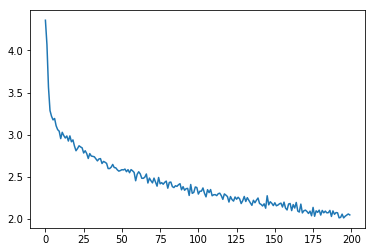

In [18]:
# イテレーション毎の損失の値を描画
plt.figure()
plt.plot(all_losses)
plt.show()

In [19]:
# 訓練後にサンプルを表示するための推論用関数
# start_lettersで渡されたそれぞれの文字を先頭として名前を生成し表示
def samples(category, start_letters='アイウ'):
    """
    Get multiple samples from one category and evaluate samples from multiple starting letters
    :param category: category in tensor format
    :param start_letters: several alphabet letters (concatnated) which can be first letter of new name
    :return: None
    """
    max_length = 10
    category_tensor = Variable(categoryTensor(category))
    for start_letter in start_letters:
        input = Variable(inputTensor(start_letter))
        hidden = lstm.initHidden()
        output_name = start_letter
        for i in range(max_length):
            output, hidden = lstm(category_tensor, input[0], hidden)
            topv, topi = output.data.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = Variable(inputTensor(letter))

        print(category, output_name)

In [20]:
# テスト1
samples('boys_name', 'カキクケコ')

boys_name カイチ
boys_name キョウスケ
boys_name クン
boys_name ケン
boys_name コンヤ


In [21]:
# テスト2
samples('girls_name', 'カキクケコ')

girls_name カナ
girls_name キナ
girls_name クナ
girls_name ケイ
girls_name コウカ
